# 0. Interactive Cloud Version 
(Select GPU/TPU for faster training of the Tensorflow models).

https://colab.research.google.com/github/MariusGuerard/emg_sign_recognition/blob/master/somos_data_analysis.ipynb

In [1]:
import time
a = time.time()

In [2]:
# Set to true to run in colab
RUN_IN_COLAB = False

In [3]:
if RUN_IN_COLAB:
    ### Installing non-colab library.
    !pip install pyriemann
    
    ### Downloading custom libraries (not available with pip)
    !wget https://raw.githubusercontent.com/MariusGuerard/emg_sign_recognition/master/helper_function.py \
        -O /tmp/helper_function.py
    !wget https://raw.githubusercontent.com/MariusGuerard/emg_sign_recognition/master/viz.py \
        -O /tmp/viz.py

    ### Add the tmp directory to the path to be able to import the custom libraries.
    import sys
    sys.path.append('/tmp/')

    ### Downloading and extracting the data
    !wget https://github.com/MariusGuerard/emg_sign_recognition/blob/master/data/data_somos.zip?raw=true\
        -O /tmp/data_somos.zip
    !unzip -o /tmp/data_somos.zip -d /tmp/data_somos/
    # Directory of the data
    data_dir = '/tmp/data_somos/JAN20/'
    
else:
    data_dir = 'data/data_somos/JAN20/'

# Start of the notebook if ran in local

In [4]:
import os, pickle
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from os.path import join
from glob import glob
import time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
import seaborn as sns
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
#from tensorflow.keras import Sequential
tf.__version__

import pyriemann
from pyriemann.tangentspace import TangentSpace

import helper_function as hf
import viz

Using TensorFlow backend.


In [5]:
### Number of splits in the K_Fold (for intra-session only)
N_SPLIT = 3

### Number of hardware acquisitions to consider as a trial.
# The higher the number of steps, the longer the decision time but the better the accuracy.
# With current hardware, the sampling time is 4ms (=250Hz) for all 8 electrodes, so N_STEPS of 100 correspond to trial time (decision time) of 400ms
N_STEPS = 100

### Set to True to load processed data previously saved. 
# Set to False to re-process data with different parameters.
LOAD_DATA = False

### Set to True if you want to use to train the DNN models (which takes way more time than the other algorithms).
TRAIN_DNN = True

# 1. Preliminary comments

In [6]:
# Labels that correspond to the order (0 = Nothing, 1 = Rock, ...)
label_dic = {'Nothing': 0, 'Rock': 1, 'Paper': 2, 'Scissors': 3, 'Ok': 4}

# 2. Loading the Data.

In [10]:
### Functions to read the data in pandas DataFrame with the filenames as values of column 'exp'.
data_dir = 'data/JAN20/' 

read_somos_csv = lambda path: pd.read_csv(path, sep=',', names = ['time', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'label'], skiprows=1)

def combine_pd(pattern, data_dir=data_dir):
    df = pd.concat([read_somos_csv(x) for x in glob(data_dir + pattern + 'txt')])
    df['exp'] = [pattern] * len(df)
    return df

In [11]:
patterns = ['mg*s1*', 'mg*s2*', 'rr*s1*', 'rr*s2*']

In [12]:
data_df = pd.concat([combine_pd(pattern) for pattern in patterns])

In [13]:
data_df.sample(10)

,time,c0,c1,c2,c3,c4,c5,c6,c7,label,exp
1241,5403,127,128,126,128,126,124,123,126,0,rr*s2*
5355,21814,125,129,127,127,130,128,128,128,0,mg*s1*
9958,40595,125,128,127,127,126,127,127,127,1,rr*s2*
1068,4698,127,128,127,127,125,128,127,127,0,rr*s1*
19764,81289,129,125,127,128,126,129,130,128,3,rr*s1*
9830,40584,128,126,129,127,127,128,127,127,1,rr*s1*
24177,99030,128,122,125,129,128,129,129,127,3,mg*s1*
12966,53032,134,131,121,124,126,128,128,128,2,mg*s1*
1495,5894,127,128,127,128,128,128,128,128,0,rr*s2*
22239,91214,127,121,133,133,124,126,127,129,3,rr*s1*


In [14]:
data_df.describe()

,time,c0,c1,c2,c3,c4,c5,c6,c7,label
count,731682.000000,731682.000000,731682.000000,731682.000000,731682.000000,731682.000000,731682.000000,731682.000000,731682.000000,731682.000000
mean,62558.191848,127.505144,127.507004,127.506409,127.504250,127.505813,127.506537,127.505465,127.503991,2.001328
std,36043.299100,3.565628,4.235870,3.714308,2.794727,2.724745,2.384146,2.779323,2.851516,1.413178
min,4.000000,61.000000,48.000000,27.000000,53.000000,82.000000,54.000000,54.000000,44.000000,0.000000
25%,31345.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,1.000000
50%,62552.000000,128.000000,128.000000,127.000000,127.000000,128.000000,128.000000,128.000000,128.000000,2.000000
75%,93800.750000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,3.000000
max,125014.000000,190.000000,245.000000,193.000000,194.000000,217.000000,210.000000,191.000000,249.000000,4.000000


# 3. Pre-processing of the data

## 3.0 Giving same labels sign map as in Kaggle

In [15]:
labels = data_df.label.values

In [16]:
# Changing the resting state 0 into -1
tmp = np.where(labels==0, -1, labels)
# Changing the Rock 1 in Rock 0
tmp = np.where(tmp==1, 0, tmp)
# Changing the Scissor 3 in Scissors 1
tmp = np.where(tmp==3, 1, tmp)
# Changing the Ok 4 in OK 3
labels = np.where(tmp==4, 3, tmp)

In [17]:
data_df.label = labels

For now let's remove the 'rest' sign (to have a better comparison with the MYO), but we can look at it later.

In [18]:
data_df = data_df[data_df.label != -1]

## 3.1 Batching

The data are being batched by time windows of size 'N_STEPS': (t0_sensor0, ..., t0_sensor8, t1_sensor0, ..., t1_sensor8, ..., tN_STEPS_sensor0, tN_STEPS_sensor8).

In [19]:
### Tagging the start and end of the signs (that allows to not take time window that contains multiple label)
start_sign = np.where(np.diff(data_df.label) != 0)[0]
# We had a margin at the start and the end of the signs to get the stationary signal coresponding to these signs.
end_sign = np.append(start_sign[1:], len(data_df)) - 1000
start_sign += 1000

We have 24 files with 5 signs each (including rest) so we should have 5 * 24 - 1 = 119 changes of sign, or 4 * 24 - 1 = 95 (in case with no rest)

In [20]:
len(start_sign)

95

This step can take a bit of time (~10-60s depending on your computer and your batching parameters)

In [21]:
emg_list = []
label_list = []
exp_list = []
for j in range(len(start_sign)):
    batchs = range(start_sign[j], end_sign[j] - N_STEPS, N_STEPS)
    #print(batchs)
    emg_list.append([data_df.iloc[i: i+N_STEPS, 1: -2].values.flatten() for i in batchs])
    # Similarly to the kaggle data let's create samples of 10 time steps of 8 channel: t0_sensor0, t0_sensor1, ..., t10_sensor0, ..., t10_sensor8.
    label_list.append([data_df.iloc[i, -2] for i in batchs])
    # Similarly to the kaggle data let's create samples of 10 time steps of 8 channel: t0_sensor0, t0_sensor1, ..., t10_sensor0, ..., t10_sensor8.
    exp_list.append([data_df.iloc[i, -1] for i in batchs])
emg = np.concatenate(emg_list)
labels = np.hstack(label_list)
exps = np.hstack(exp_list)

Our EMG matrix should now have the shape (~len(raw)/N_STEPS, N_ELEC * N_STEPS) 

In [22]:
emg.shape

(3856, 800)

### 3.2 Separation in 4 datasets (2 sessions for 2 users)

In [23]:
# Save the data pre-processed in a pickle to go faster at next execution 
# (You need to set LOAD_DATA to False if some parameters relative to this data needs to be modified).
if 'data_batched.pickle' in os.listdir() and LOAD_DATA:
    with open('data_batched.pickle', 'rb') as handle:
        data_per_exp = pickle.load(handle)
else:
    data_per_exp = {}
    for exp_name in patterns:
        idx_exp = np.where(exps==exp_name)[0]
        data_per_exp[exp_name] = {'raw': np.float_(emg[idx_exp]), 'labels': labels[idx_exp]}
        print(len(emg[idx_exp]))
    with open('data_batched.pickle', 'wb') as handle:
        pickle.dump(data_per_exp, handle)

931
978
973
974


# 4. Model on each dataset separately

In this section, we are just using each dataset separately to both fit and evaluate different models. That gives an idea of the best-case scenario (when the user tries the wrist band just after having calibrating it)

In [24]:
# Dictionary containing all accuracy and models for the intra-session experiment.
result_intra = {}

In [25]:
# For the intra-session experiment, we split the dataset into N_SPLIT stratified Kfold for better test accuracy estimation.
k_fold = StratifiedKFold(n_splits=N_SPLIT, shuffle=True, random_state=7)

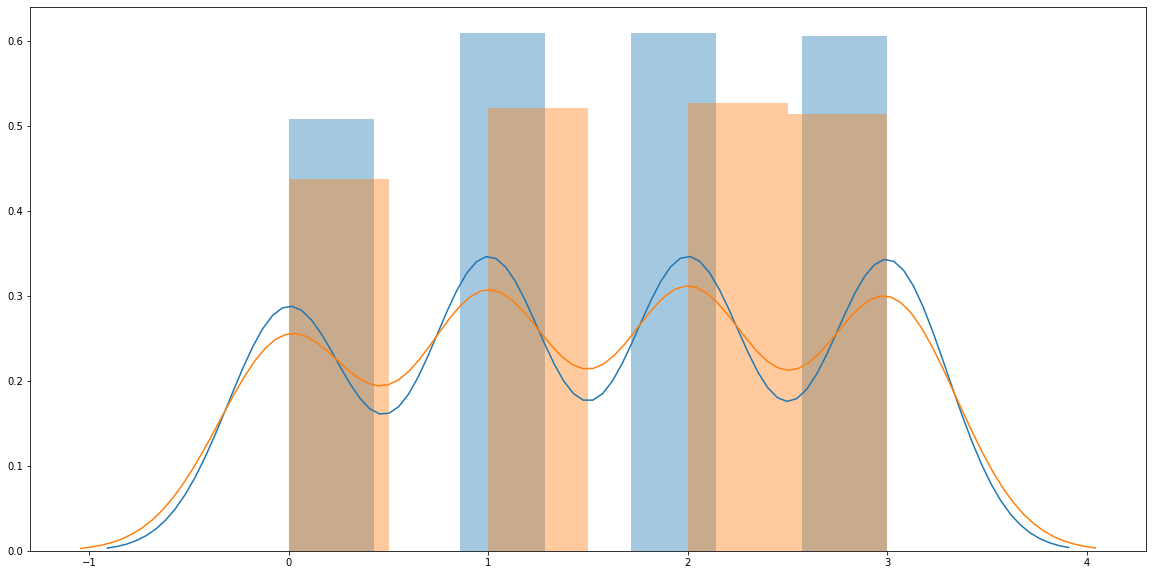

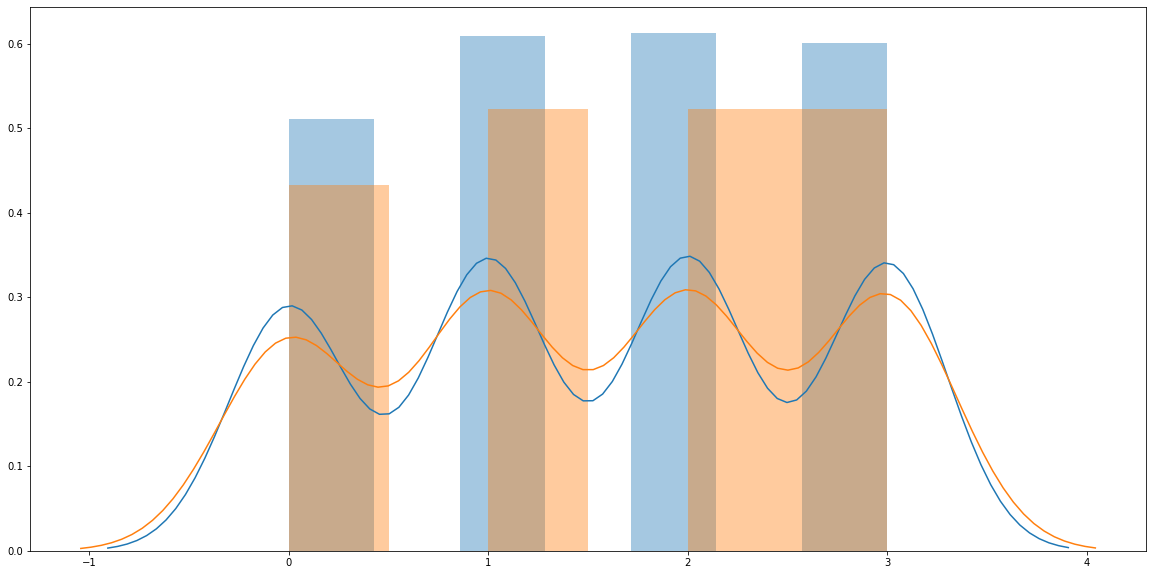

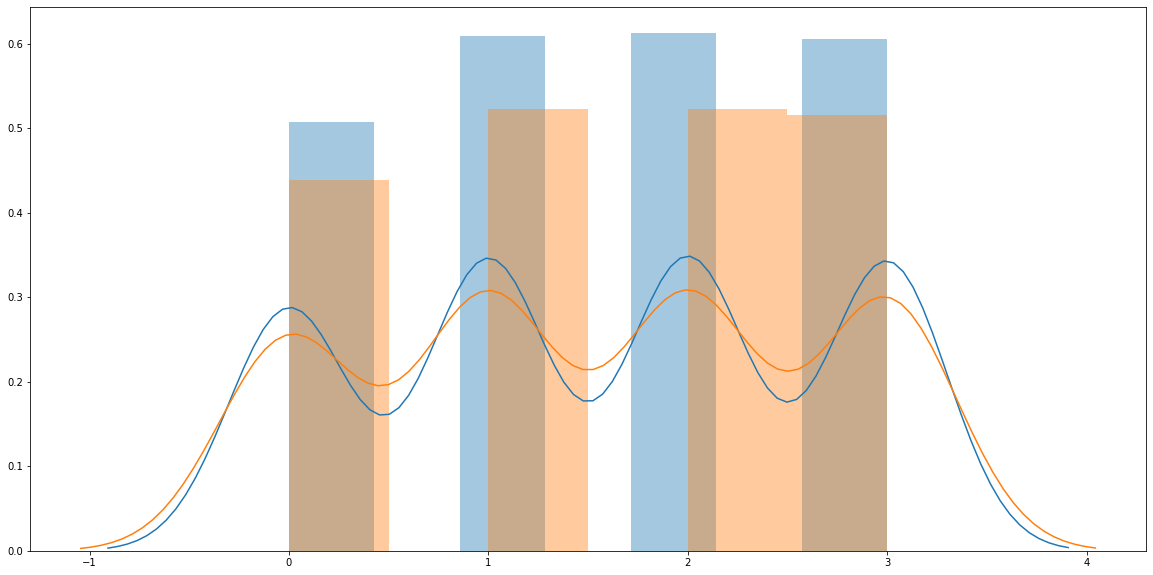

In [26]:
### Let's plot the distribution of the labels for the train set and the validation test of each Fold of one experiment.
X = data_per_exp['mg*s1*']['raw']
y = data_per_exp['mg*s1*']['labels']
for train_indices, test_indices in k_fold.split(X, y):
    plt.figure()
    sns.distplot(y[train_indices])
    sns.distplot(y[test_indices])

The plots above confirm that the 4 signs are equally represented in our 3 splits (as we used a stratified KFold).

## 4.1 Using the Row Data

This is if we were to use the models directly on the N_channels x N_time_steps features of a sample. Here it is very important to scale the data, as the signal sent from the FPGA has a very big biais relatively to the signal energy, and as the biais can be different for each electrodes.

### 4.1.0 Naive Model

This random model is used to see what accuracy we would get by guessing randomly what sample corresponds to what sign. In average, we should have 25% accuracy if we have 4 signs and 20% accuracy if we have 5 signs.

In [27]:
class ChanceDetector():
    """Just a random number generator.
    """
    def __init__(self, n_class):
        self.n_class = 4

    def fit(self, X_train, y_train):
        return None
    
    def predict(self, X_test):
        lx = len(X_test)
        return np.random.randint(0, self.n_class, lx)

In [28]:
### Scikit-learn pipeline combining a standard scaler and our model.
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('naive',  ChanceDetector(4)))
pipeline_naive = Pipeline(estimators)

In [29]:
### Fit and Test our model on the k_fold and store the results in result_intra.
result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=pipeline_naive, kfold=k_fold, key_result='naive_raw', key_data='raw')

mg*s1* [0.2604501607717042, 0.2903225806451613, 0.27419354838709675] 0.27498876326798743
mg*s2* [0.2147239263803681, 0.2883435582822086, 0.25153374233128833] 0.25153374233128833
rr*s1* [0.24307692307692308, 0.2222222222222222, 0.22530864197530864] 0.2302025957581513
rr*s2* [0.25846153846153846, 0.24, 0.2716049382716049] 0.25668882557771444


As expected we have scores around 25% using the naive model on each dataset.

### 4.1.1 With Logistic Regression

In [30]:
### Scikit-learn pipeline combining a standard scaler and our model.
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('lr', LogisticRegression(solver='lbfgs', multi_class='multinomial')))
pipeline_lr = Pipeline(estimators)

In [31]:
### Fit and Test our model on the k_fold and store the results in result_intra.
result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=pipeline_lr, kfold=k_fold, key_result='lr_raw', key_data='raw')

mg*s1* [0.2508038585209003, 0.23548387096774193, 0.23548387096774193] 0.24059053348546136
mg*s2* [0.25766871165644173, 0.25153374233128833, 0.25766871165644173] 0.2556237218813906
rr*s1* [0.27076923076923076, 0.2222222222222222, 0.25] 0.24766381766381765
rr*s2* [0.2553846153846154, 0.26153846153846155, 0.2716049382716049] 0.2628426717315606


Barely above chance level

### 4.1.2. With Deep Neural Net (DNN)

In [32]:
def create_model(weights='initial_weights.hd5', n_features=800):
    """Function to create model, required for using KerasClassifier and wrapp a Keras model inside a 
    scikitlearn form.
    We added a weight saving/loading to remove the randomness of the weight initialization (for better comparison).
    """
    model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(34, activation='relu', input_shape=(n_features,)),
    tf.keras.layers.Dense(17, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax'),
])
    
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    if weights is None:
        model.save_weights('initial_weights.hd5')
    else:
        model.load_weights(weights)
    return model

In [33]:
def create_model_variance(weights='initial_weights.hd5'):
    return create_model(weights=weights, n_features=8)

In [34]:
def create_model_covariance(weights='initial_weights.hd5'):
    return create_model(weights=weights, n_features=36)

In [32]:
generate_weights = create_model(weights=None)

W0604 15:56:00.367372 140555475265280 deprecation.py:506] From /home/marius/miniconda3/envs/stats/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [35]:
### Scikit-learn pipeline combining a standard scaler and our model.
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('dnn', KerasClassifier(build_fn=create_model, epochs=100, verbose=0)))
pipeline_dnn = Pipeline(estimators)

In [36]:
### Fit and Test our model on the k_fold and store the results in result_intra.
# This training can take a bit of time.
if TRAIN_DNN:
    result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=pipeline_dnn, kfold=k_fold, key_result='dnn_raw', key_data='raw')

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for initial_weights.hd5

## 4.2 Using Covariances

Just as for EEG, most of the information should be contains in the covariance matrix of each sample.
For 8 channels and N_STEPS time steps samples, this matrix will have dimension 8x8

In [37]:
i = start_sign[0]
data_df.iloc[i: i+10]

,time,c0,c1,c2,c3,c4,c5,c6,c7,label,exp
13136,54042,128,129,126,133,124,126,129,127,2,mg*s1*
13137,54045,127,122,128,138,126,130,128,132,2,mg*s1*
13138,54049,128,128,128,125,130,129,130,124,2,mg*s1*
13139,54052,128,135,130,125,129,128,129,127,2,mg*s1*
13140,54055,123,132,127,130,127,129,127,131,2,mg*s1*
13141,54059,122,123,127,133,126,127,130,127,2,mg*s1*
13142,54062,129,128,126,130,128,127,126,130,2,mg*s1*
13143,54066,131,130,129,123,125,129,129,128,2,mg*s1*
13144,54070,125,144,128,136,120,126,129,122,2,mg*s1*
13145,54072,130,102,127,123,131,126,130,124,2,mg*s1*


In [38]:
# Save the data pre-processed with covariance in a pickle to go faster at next execution 
# (You need to set LOAD_DATA to False if some parameters relative to this data needs to be modified).
if 'cov.pickle' in os.listdir() and LOAD_DATA:
    with open('cov.pickle', 'rb') as handle:
        data_per_exp = pickle.load(handle)
else:
    for key, data in data_per_exp.items():
        # X: your EEG data, in format Ntrials x Nchannels X Nsamples
        emg_rows = data['raw']
        X = np.array([x.reshape(N_STEPS, 8).transpose() for x in emg_rows])
        # Covariance Matrix with Ledoit and Wolf Regularization (https://projecteuclid.org/euclid.aos/1342625460)
        cov = pyriemann.estimation.Covariances(estimator='lwf').fit_transform(X)
        # Computation of the vectorized matrix to used each elements as features (without Tangeant Space Projection).
        covec = np.array([hf.vectorize_cov(cov_mat) for cov_mat in cov])
        # The variance correspond to the diagonal elements of the covariance.
        var = np.array([cov_mat.diagonal() for cov_mat in cov])
        y = data['labels']
        data['matrix'] = X
        data['cov'] = cov
        data['covec'] = covec
        data['var'] = var
    with open('cov.pickle', 'wb') as handle:
        pickle.dump(data_per_exp, handle)

In [39]:
data_per_exp['mg*s1*']['matrix'].shape

(931, 8, 100)

In [40]:
data_per_exp['mg*s1*']['var'].shape

(931, 8)

In [41]:
data_per_exp['mg*s1*']['covec'].shape

(931, 36)

In [42]:
data_per_exp['mg*s1*']['cov'].shape

(931, 8, 8)

### 4.2.1 Logistic Regression on Variance

We first look only at the variance (or the energy of each electrodes'signal), that corresponds to the diagonal of the covariance.

In [43]:
### Scikit-learn pipeline combining a standard scaler and our model.
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('lr', LogisticRegression(solver='lbfgs', multi_class='multinomial')))
pipeline_lr = Pipeline(estimators)

In [44]:
### Fit and Test our model on the k_fold and store the results in result_intra.
result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=pipeline_lr, kfold=k_fold, key_result='logreg_var', key_data='var')

mg*s1* [0.9742765273311897, 0.9741935483870968, 0.9774193548387097] 0.9752964768523321
mg*s2* [0.9846625766871165, 0.9601226993865031, 0.9662576687116564] 0.9703476482617587
rr*s1* [0.9784615384615385, 0.9845679012345679, 0.9907407407407407] 0.9845900601456158
rr*s2* [0.96, 0.9753846153846154, 0.9814814814814815] 0.9722886989553655


Way better results than everything else we tried so far! 
For this experiment with not much class, and only static signs, most of the discriminative information is contained in the variance.

### 4.2.2 DNN on Variance

In [45]:
generate_weights = create_model_variance(weights=None)

In [46]:
### Scikit-learn pipeline combining a standard scaler and our model.
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('dnn', KerasClassifier(build_fn=create_model_variance, epochs=100, verbose=0)))
pipeline_dnn = Pipeline(estimators)

In [47]:
### Fit and Test our model on the k_fold and store the results in result_intra.
if TRAIN_DNN:
    result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=pipeline_dnn, kfold=k_fold, key_result='dnn_var', key_data='var')

mg*s1* [0.9871382636655949, 0.9967741935483871, 0.9967741935483871] 0.9935622169207896
mg*s2* [0.9969325153374233, 0.9785276073619632, 0.9846625766871165] 0.9867075664621677
rr*s1* [0.9876923076923076, 0.9938271604938271, 0.9938271604938271] 0.9917822095599873
rr*s2* [0.9661538461538461, 0.9846153846153847, 0.9753086419753086] 0.9753592909148465


Let's try to add all covariances elements to see if we gain in accuracy.

### 4.2.3 Log Reg on covariance Matrix

Let's now look if adding the non-diagonal elements of the covariance matrix can help to gain in accuracy.

In [48]:
### Scikit-learn pipeline combining a standard scaler and our model.
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('lr', LogisticRegression(solver='lbfgs', multi_class='multinomial')))
pipeline_logreg = Pipeline(estimators)

In [49]:
### Fit and Test our model on the k_fold and store the results in result_intra.
result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=pipeline_logreg, kfold=k_fold, key_result='logreg_covec', key_data='covec')

mg*s1* [0.9742765273311897, 0.9838709677419355, 0.964516129032258] 0.9742212080351278
mg*s2* [0.9693251533742331, 0.950920245398773, 0.9631901840490797] 0.9611451942740287
rr*s1* [0.9846153846153847, 0.9814814814814815, 0.9938271604938271] 0.9866413421968977
rr*s2* [0.9507692307692308, 0.9661538461538461, 0.9845679012345679] 0.9671636593858817


### 4.2.4 DNN on covariance Matrix

In [50]:
generate_weights = create_model_covariance(weights=None)

In [51]:
### Scikit-learn pipeline combining a standard scaler and our model.
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('dnn', KerasClassifier(build_fn=create_model_covariance, epochs=100, verbose=0)))
pipeline_dnn = Pipeline(estimators)

In [52]:
### Fit and Test our model on the k_fold and store the results in result_intra.
if TRAIN_DNN:
    result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=pipeline_dnn, kfold=k_fold, key_result='dnn_covec', key_data='covec')

mg*s1* [0.9839228295819936, 0.9903225806451613, 0.9870967741935484] 0.9871140614735677
mg*s2* [0.9815950920245399, 0.9631901840490797, 0.9570552147239264] 0.9672801635991819
rr*s1* [0.9815384615384616, 0.9753086419753086, 0.9876543209876543] 0.9815004748338082
rr*s2* [0.9476923076923077, 0.9476923076923077, 0.9722222222222222] 0.9558689458689459


(I also ran it with unscaled data and it doesn't seem to change much here as the covariance are already scaled)

### 4.2.5 Euclidean Minimum Distance to Mean (Eucl MDM)

Now let's try to look at simpler algorithm (that might have bigger biais but potentially less variance as they have less parameters). We first look at the MDM in Euclidean geometry. For which we should be able to use covec or cov indifferently.

With Scaling.

In [53]:
### Scikit-learn pipeline combining a standard scaler and our model.
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('MDM', hf.MDM()))
pipeline_MDM = Pipeline(estimators)

In [54]:
result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=pipeline_MDM, kfold=k_fold, key_result='eucl_mdm_covec', key_data='covec')

mg*s1* [0.819935691318328, 0.8032258064516129, 0.7903225806451613] 0.8044946928050342
mg*s2* [0.8006134969325154, 0.7423312883435583, 0.8312883435582822] 0.7914110429447853
rr*s1* [0.7538461538461538, 0.7839506172839507, 0.7561728395061729] 0.7646565368787591
rr*s2* [0.9107692307692308, 0.8830769230769231, 0.9012345679012346] 0.8983602405824628


Without Scaling.

In [55]:
result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=hf.MDM(), kfold=k_fold, key_result='eucl_mdm_covec', key_data='covec')

mg*s1* [0.842443729903537, 0.864516129032258, 0.9032258064516129] 0.8700618884624692
mg*s2* [0.8588957055214724, 0.7944785276073619, 0.8680981595092024] 0.8404907975460123
rr*s1* [0.8276923076923077, 0.8580246913580247, 0.7932098765432098] 0.8263089585311807
rr*s2* [0.7938461538461539, 0.8523076923076923, 0.8518518518518519] 0.8326685660018992


### 4.2.6 Riemannian MDM 

The covariance matrix are SPD matrix and the distance between SPD matrix can be measured with Riemanian metrics that have nice properties.
(See for example how it is applied to EEG signal in https://hal.archives-ouvertes.fr/hal-01570120/document)

Without Scaling.

In [56]:
result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=pyriemann.classification.MDM(), kfold=k_fold, key_result='riemann_mdm_cov', key_data='cov')

mg*s1* [0.8488745980707395, 0.9387096774193548, 0.9225806451612903] 0.9033883068837949
mg*s2* [0.9355828220858896, 0.9355828220858896, 0.9386503067484663] 0.9366053169734152
rr*s1* [0.9384615384615385, 0.9197530864197531, 0.9320987654320988] 0.9301044634377967
rr*s2* [0.9076923076923077, 0.9230769230769231, 0.9444444444444444] 0.9250712250712251


### 4.2.7 Tangeant Space + Log Reg

Another use of the Riemannian geometry is to project the covariance matrix on a tangeant space that is euclidean and on which we can apply usual machine learning algorithms. You can think of the projection as the translation of a sphere into a plan (like in the case of world maps).

In [57]:
### Scikit-learn pipeline combining a standard scaler and our model.
estimators = []
estimators.append(('ts', TangentSpace()))
estimators.append(('lr', LogisticRegression(solver='lbfgs', multi_class='multinomial')))
pipeline_tang_lr = Pipeline(estimators)

In [58]:
result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=pipeline_tang_lr, kfold=k_fold, key_result='ts_logreg_cov', key_data='cov')

mg*s1* [0.9839228295819936, 0.9903225806451613, 0.9870967741935484] 0.9871140614735677
mg*s2* [0.99079754601227, 0.9662576687116564, 0.9754601226993865] 0.9775051124744376
rr*s1* [0.9938461538461538, 0.9938271604938271, 0.9969135802469136] 0.9948622981956315
rr*s2* [0.9723076923076923, 0.9723076923076923, 0.9876543209876543] 0.9774232352010129


### 4.2.8 Tangeant Space + DNN

In [59]:
# Function to create model, required for KerasClassifier
#def create_model_covariance(weights='initial_weights.hd5'):
#    return create_model(weights=weights, n_features=36)
generate_weights = create_model_covariance(weights=None)

In [60]:
estimators = []
#estimators.append(('standardize', StandardScaler()))
estimators.append(('ts', TangentSpace()))
estimators.append(('dnn', KerasClassifier(build_fn=create_model_covariance, epochs=100, verbose=0)))
pipeline_tang_dnn = Pipeline(estimators)

In [61]:
if TRAIN_DNN:
    result_intra = hf.record_results_kfold(data_per_exp, result_intra, model=pipeline_tang_dnn, kfold=k_fold, key_result='ts_dnn_cov', key_data='cov')

mg*s1* [0.9935691318327974, 1.0, 1.0] 0.9978563772775991
mg*s2* [1.0, 0.9815950920245399, 0.9877300613496932] 0.9897750511247444
rr*s1* [0.9938461538461538, 0.9876543209876543, 1.0] 0.9938334916112694
rr*s2* [0.9753846153846154, 0.9815384615384616, 0.9969135802469136] 0.9846122190566634


### 4.2.9 Using power of the affine-invariant metric as hyperparameter for Log Reg

In [188]:
import geom_function as gf

POWERS = np.linspace(0.2, 2., 10)

result_intra = gf.run_intrasession_on_powers(
    result_intra, data_per_exp, 
    key_estimator='lr', key_result='ts_lr_cov', 
    k_fold=k_fold, powers=POWERS)  

mg*s1* [0.9839228295819936, 0.9967741935483871, 0.9935483870967742] 0.991415136742385
mg*s2* [0.9815950920245399, 0.9601226993865031, 0.9693251533742331] 0.9703476482617587
rr*s1* [0.9876923076923076, 0.9907407407407407, 1.0] 0.9928110161443495
rr*s2* [0.9784615384615385, 0.9784615384615385, 0.9938271604938271] 0.9835834124723014
mg*s1* [0.9839228295819936, 0.9967741935483871, 0.9935483870967742] 0.991415136742385
mg*s2* [0.9815950920245399, 0.9601226993865031, 0.9723926380368099] 0.9713701431492843
rr*s1* [0.9876923076923076, 0.9907407407407407, 1.0] 0.9928110161443495
rr*s2* [0.9784615384615385, 0.9753846153846154, 0.9938271604938271] 0.9825577714466603
mg*s1* [0.9839228295819936, 0.9967741935483871, 0.9935483870967742] 0.991415136742385
mg*s2* [0.9815950920245399, 0.9601226993865031, 0.9693251533742331] 0.9703476482617587
rr*s1* [0.9876923076923076, 0.9938271604938271, 1.0] 0.9938398227287116
rr*s2* [0.9784615384615385, 0.9753846153846154, 0.9938271604938271] 0.9825577714466603
mg*s

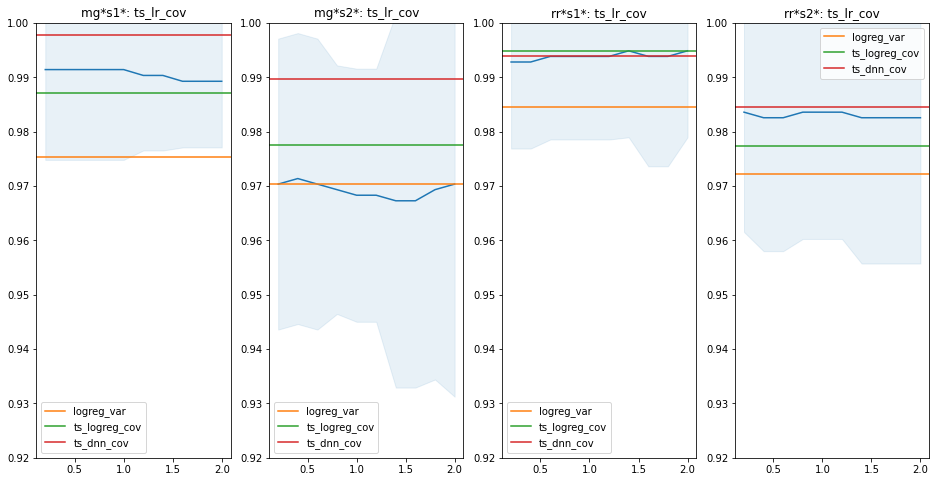

In [199]:
gf.plot_intrasession_on_powers(result_intra, key_result='ts_lr_cov', powers=POWERS)

### 4.2.10 Using power as hyperparameter for DNN

In [196]:
result_intra = gf.run_intrasession_on_powers(
    result_intra, data_per_exp, 
    key_estimator='dnn', key_result='ts_dnn_cov', 
    k_fold=k_fold, powers=POWERS)  

mg*s1* [0.9903536977491961, 0.9967741935483871, 0.9967741935483871] 0.9946340282819902
mg*s2* [0.9877300613496932, 0.9785276073619632, 0.9785276073619632] 0.9815950920245399
rr*s1* [0.9846153846153847, 0.9876543209876543, 0.9938271604938271] 0.988698955365622
rr*s2* [0.9661538461538461, 0.9753846153846154, 0.9938271604938271] 0.9784552073440963
mg*s1* [0.9903536977491961, 0.9967741935483871, 0.9967741935483871] 0.9946340282819902
mg*s2* [0.9877300613496932, 0.9785276073619632, 0.9723926380368099] 0.9795501022494887
rr*s1* [0.9876923076923076, 0.9876543209876543, 0.9907407407407407] 0.988695789806901
rr*s2* [0.9661538461538461, 0.9753846153846154, 0.9876543209876543] 0.976397594175372
mg*s1* [0.9903536977491961, 1.0, 0.9967741935483871] 0.9957092970991944
mg*s2* [0.99079754601227, 0.9754601226993865, 0.9785276073619632] 0.9815950920245399
rr*s1* [0.9876923076923076, 0.9783950617283951, 0.9907407407407407] 0.9856093700538144
rr*s2* [0.963076923076923, 0.9753846153846154, 0.99074074074074

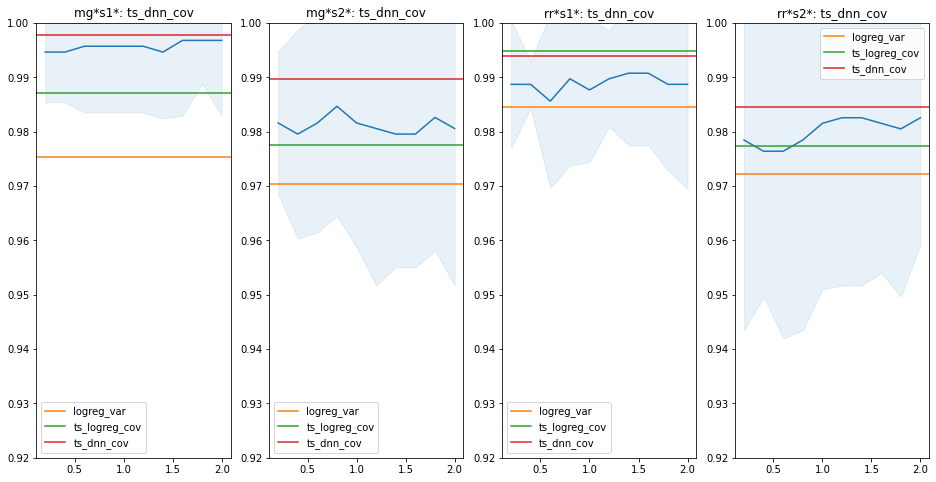

In [200]:
gf.plot_intrasession_on_powers(result_intra, key_result='ts_dnn_cov', powers=POWERS)

## 4.3 Plotting intra-sessions results

In [60]:
acc_vec = np.array([acc_model['acc_all'] for key, acc_model in result_intra.items()]).transpose()
model_labels = result_intra.keys()

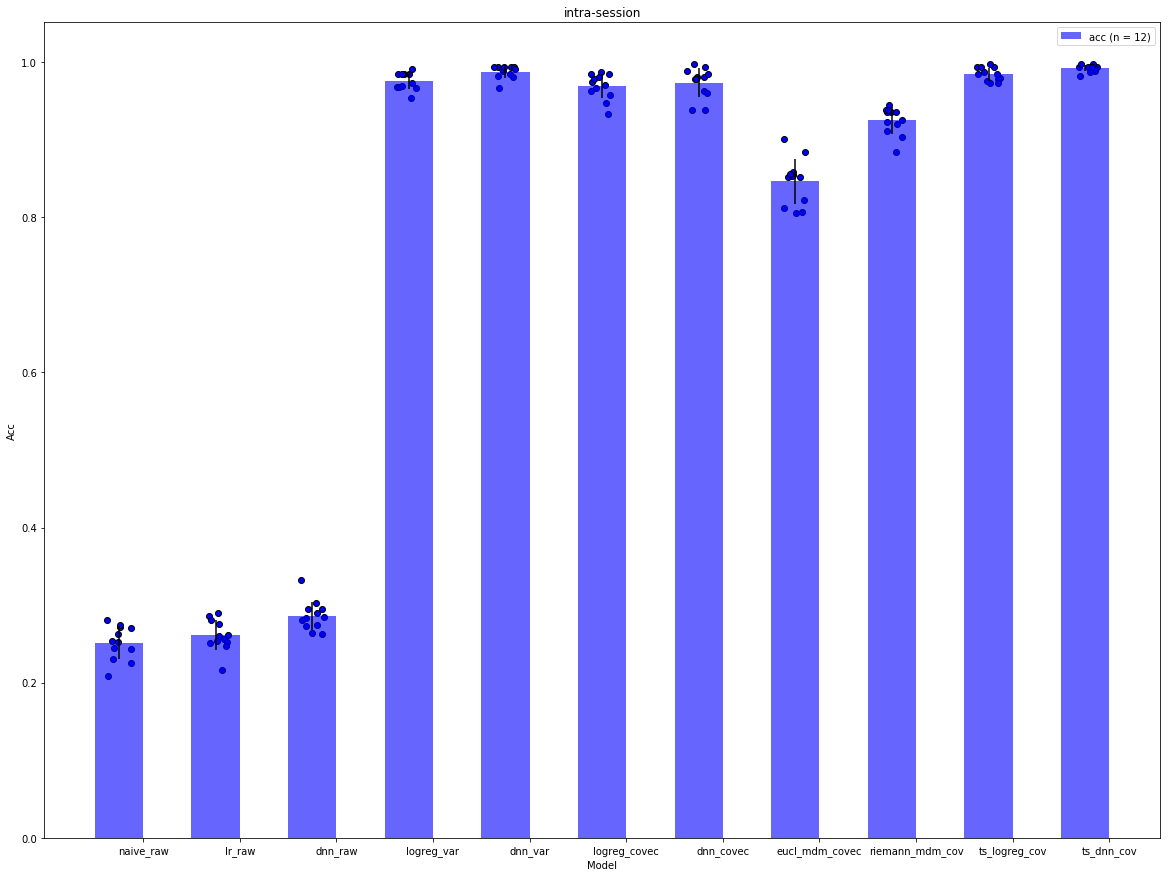

In [61]:
viz.bar_plot_scatter_comp([acc_vec], model_labels, 'intra-session', ['acc'])

We notice that most of the information of the signal seem to be contained in the covariance matrix of the electrodes (and particularly in its diagonal: the variances)

In [62]:
acc_var = np.array([acc_model['acc_all'] for key, acc_model in result_intra.items() if 'raw' not in key]).transpose()
model_labels = [x for x in result_intra.keys() if 'raw' not in x]

(0.7, 1.1)

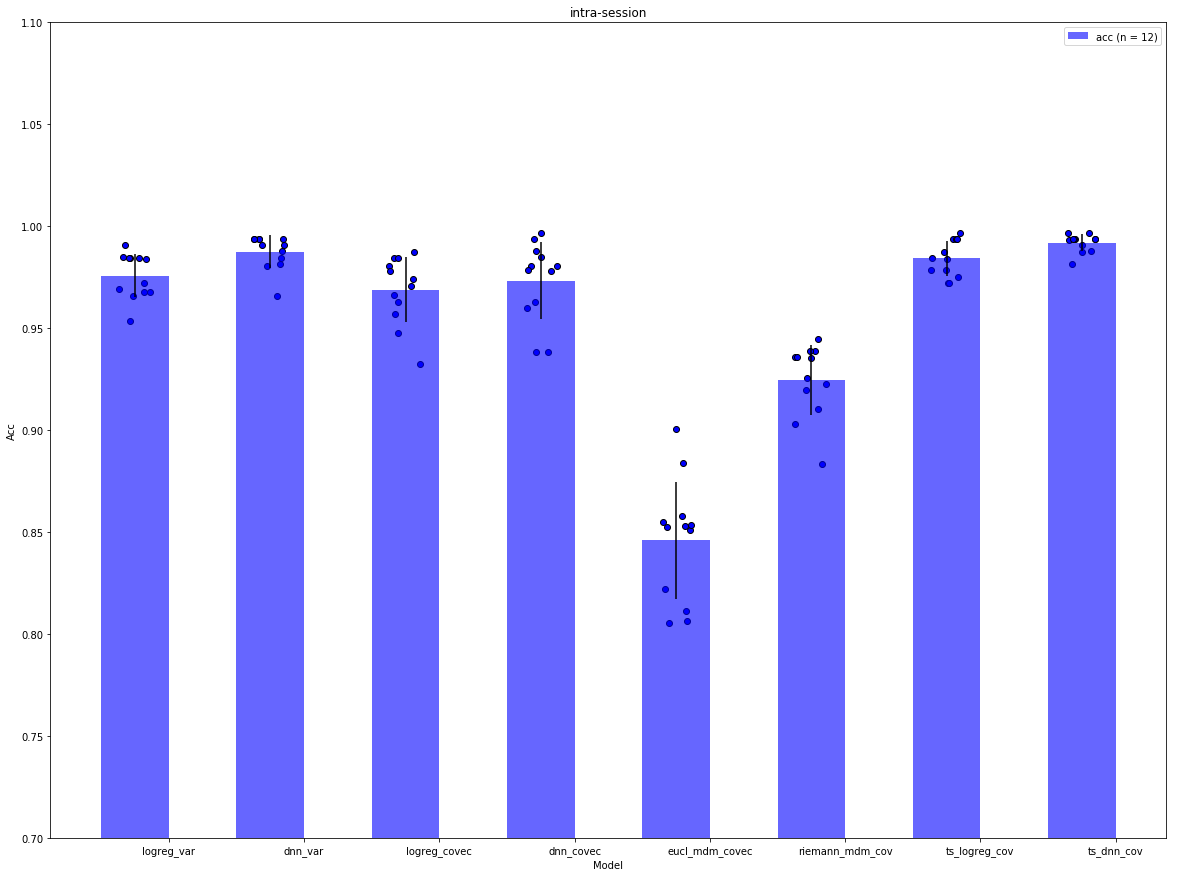

In [63]:
viz.bar_plot_scatter_comp([acc_var], model_labels, 'intra-session', ['acc'])
plt.ylim([0.7, 1.1])

Depending on the value you chose for N_STEPS, you may or may not see a big difference between this algorithms but you should observe a this kind of trend (at least with N_STEPS = 100):
- At least with these models training on raw data is completely inefficient (might works better with RNN, but might also probably overfit between sessions...)
- For very simple models (MDM), Riemannian framework gives better result that the usual euclidean geometry.
- For standard models (logreg, DNN), the accuracy is similar with slightly better results for model using tangeant space.

# 5. Model on Inter-session

Here we train model on one session, and then test this model on another session, after the user removed and repositioned the armband. This is to evaluate what kind of performance we could get without having to recalibrate the device everytime the users are removing it.

## 5.1 Euclidean MDM

In [170]:
### This dictionary will contain the results for the inter-session experiments
result_intersess = {}

With Scaling.

In [216]:
### Scikit-learn pipeline combining a standard scaler and our model.
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('MDM', hf.MDM()))
pipeline_MDM = Pipeline(estimators)

In [217]:
result_intersess = hf.train_test_intersession(data_per_exp, result_intersess, pipeline_MDM, key_result='eucl_mdm', data_type='covec')

mg*s1* mg*s2* 0.591002044989775
mg*s2* mg*s1* 0.5746509129967776
rr*s1* rr*s2* 0.5277207392197125
rr*s2* rr*s1* 0.5950668036998972
avg: 0.5721101252265406


Without Scaling.

In [218]:
result_intersess = hf.train_test_intersession(data_per_exp, result_intersess, hf.MDM(), key_result='eucl_mdm', data_type='covec')

mg*s1* mg*s2* 0.6503067484662577
mg*s2* mg*s1* 0.7368421052631579
rr*s1* rr*s2* 0.5277207392197125
rr*s2* rr*s1* 0.8047276464542652
avg: 0.6798993098508483


## 5.2 Riemann MDM

In [219]:
result_intersess = hf.train_test_intersession(data_per_exp, result_intersess, pyriemann.classification.MDM(), key_result='riemann_mdm', data_type='cov')

mg*s1* mg*s2* 0.6370143149284253
mg*s2* mg*s1* 0.4446831364124597
rr*s1* rr*s2* 0.6837782340862423
rr*s2* rr*s1* 0.7841726618705036
avg: 0.6374120868244078


## 5.3 Log Reg on cov

In [175]:
result_intersess = hf.train_test_intersession(data_per_exp, result_intersess, LogisticRegression(solver='lbfgs', multi_class='multinomial'), key_result='logrec_covec', data_type='covec')

mg*s1* mg*s2* 0.7014314928425358
mg*s2* mg*s1* 0.43823845327604727


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


rr*s1* rr*s2* 0.704312114989733
rr*s2* rr*s1* 0.7841726618705036
avg: 0.657038680744705


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## 5.4 Tangeant + Log Reg

In [176]:
estimators = []
estimators.append(('ts', TangentSpace()))
estimators.append(('lr', LogisticRegression(solver='lbfgs', multi_class='multinomial')))
pipeline_tang_lr = Pipeline(estimators)

In [177]:
result_intersess = hf.train_test_intersession(data_per_exp, result_intersess, pipeline_tang_lr, key_result='ts_logrec_cov', data_type='cov')

mg*s1* mg*s2* 0.7167689161554193
mg*s2* mg*s1* 0.5853920515574651
rr*s1* rr*s2* 0.6930184804928131
rr*s2* rr*s1* 0.9044193216855088
avg: 0.7248996924728015


## 5.5 DNN on Cov

In [178]:
# Function to create model, required for KerasClassifier
#def create_model_covariance(weights='initial_weights.hd5'):
#    return create_model(weights=weights, n_features=36)
generate_weights = create_model_covariance(weights=None)

In [179]:
estimators = []
#estimators.append(('standardize', StandardScaler()))
estimators.append(('ts', TangentSpace()))
estimators.append(('dnn', KerasClassifier(build_fn=create_model_covariance, epochs=100, verbose=0)))
pipeline_tang_dnn = Pipeline(estimators)

In [180]:
if TRAIN_DNN:
    result_intersess = hf.train_test_intersession(data_per_exp, result_intersess, pipeline_tang_dnn, key_result='ts_dnn_cov', data_type='cov')

mg*s1* mg*s2* 0.6779141104294478
mg*s2* mg*s1* 0.5263157894736842
rr*s1* rr*s2* 0.7073921971252567
rr*s2* rr*s1* 0.9177800616649537
avg: 0.7073505396733356


## 5.6 Tangeant + DNN

In [75]:
#def create_model_covariance(weights='initial_weights.hd5'):
#    return create_model(weights=weights, n_features=36)
generate_weights = create_model_covariance(weights=None)

In [213]:
if TRAIN_DNN:
    result_intersess = hf.train_test_intersession(data_per_exp, result_intersess, KerasClassifier(build_fn=create_model_covariance, epochs=100, verbose=0), key_result='dnn_covec', data_type='covec')

mg*s1* mg*s2* 0.7188139059304703
mg*s2* mg*s1* 0.5950590762620838
rr*s1* rr*s2* 0.8223819301848049
rr*s2* rr*s1* 0.8211716341212744
avg: 0.7393566366246583


### 5.7 Tangent + LogReg on different metrics

In [224]:
result_intersess = gf.run_intersession_on_powers(
    result_intersess, data_per_exp, 
    key_estimator='lr', key_result='ts_lr_cov', powers=POWERS)  

mg*s1* mg*s2* 0.7147239263803681
mg*s2* mg*s1* 0.4940923737916219
rr*s1* rr*s2* 0.6848049281314168
rr*s2* rr*s1* 0.9136690647482014
avg: 0.7018225732629021
mg*s1* mg*s2* 0.7147239263803681
mg*s2* mg*s1* 0.49194414607948445
rr*s1* rr*s2* 0.6817248459958932
rr*s2* rr*s1* 0.9146968139773896
avg: 0.7007724331082839
mg*s1* mg*s2* 0.7177914110429447
mg*s2* mg*s1* 0.49194414607948445
rr*s1* rr*s2* 0.6817248459958932
rr*s2* rr*s1* 0.9157245632065776
avg: 0.7017962415812251
mg*s1* mg*s2* 0.7177914110429447
mg*s2* mg*s1* 0.4908700322234157
rr*s1* rr*s2* 0.6817248459958932
rr*s2* rr*s1* 0.9146968139773896
avg: 0.7012707758099108
mg*s1* mg*s2* 0.7198364008179959
mg*s2* mg*s1* 0.49194414607948445
rr*s1* rr*s2* 0.6796714579055442
rr*s2* rr*s1* 0.9167523124357657
avg: 0.7020510793096975
mg*s1* mg*s2* 0.7177914110429447
mg*s2* mg*s1* 0.49194414607948445
rr*s1* rr*s2* 0.6745379876796714
rr*s2* rr*s1* 0.9126413155190134
avg: 0.6992287150802785
mg*s1* mg*s2* 0.7198364008179959
mg*s2* mg*s1* 0.48872180451

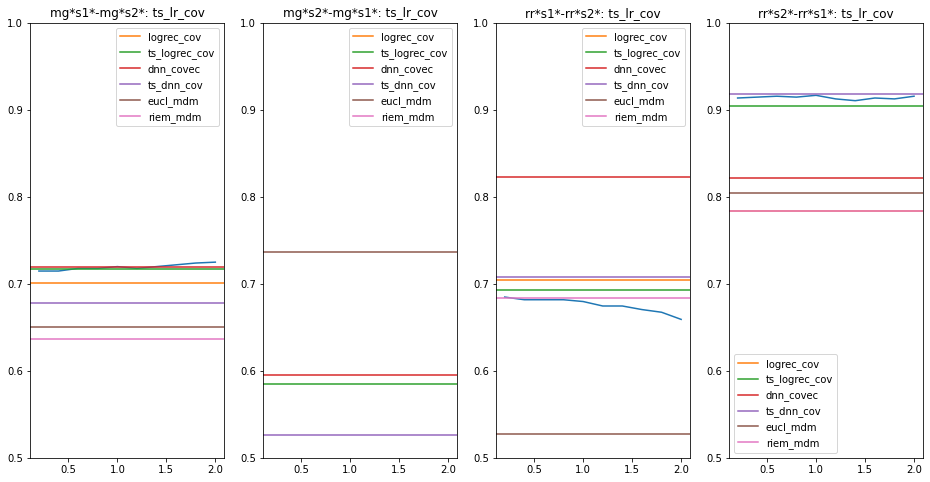

In [225]:
gf.plot_intersession_on_powers(result_intersess, key_result='ts_lr_cov', powers=POWERS, ylim=(0.5, 1.))

In [201]:
result_intersess = gf.run_intersession_on_powers(
    result_intersess, data_per_exp, 
    key_estimator='dnn', key_result='ts_dnn_cov', powers=POWERS)  

mg*s1* mg*s2* 0.7167689161554193
mg*s2* mg*s1* 0.6165413533834586
rr*s1* rr*s2* 0.6971252566735113
rr*s2* rr*s1* 0.8910585817060637
avg: 0.7303735269796132
mg*s1* mg*s2* 0.7443762781186094
mg*s2* mg*s1* 0.6251342642320086
rr*s1* rr*s2* 0.6724845995893224
rr*s2* rr*s1* 0.8365878725590956
avg: 0.7196457536247589
mg*s1* mg*s2* 0.7607361963190185
mg*s2* mg*s1* 0.6337271750805585
rr*s1* rr*s2* 0.6765913757700205
rr*s2* rr*s1* 0.9033915724563206
avg: 0.7436115799064795
mg*s1* mg*s2* 0.7658486707566462
mg*s2* mg*s1* 0.611170784103115
rr*s1* rr*s2* 0.686858316221766
rr*s2* rr*s1* 0.8992805755395683
avg: 0.7407895866552738
mg*s1* mg*s2* 0.7402862985685071
mg*s2* mg*s1* 0.6186895810955961
rr*s1* rr*s2* 0.6796714579055442
rr*s2* rr*s1* 0.8982528263103803
avg: 0.734225040970007
mg*s1* mg*s2* 0.7392638036809815
mg*s2* mg*s1* 0.6240601503759399
rr*s1* rr*s2* 0.6878850102669405
rr*s2* rr*s1* 0.8756423432682425
avg: 0.731712826898026
mg*s1* mg*s2* 0.7106339468302658
mg*s2* mg*s1* 0.6154672395273899
rr

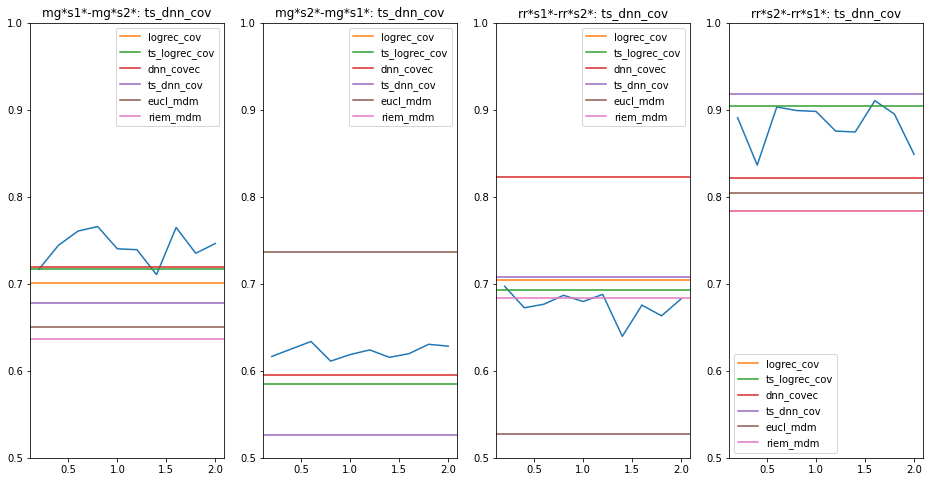

In [223]:
gf.plot_intersession_on_powers(result_intersess, key_result='ts_dnn_cov', powers=POWERS, ylim=(0.5, 1.))

## All results

In [77]:
acc_inter = np.array([list(model['acc'].values()) for key, model in result_intersess.items()]).transpose()[0]
model_labels = [x for x in result_intersess.keys()]

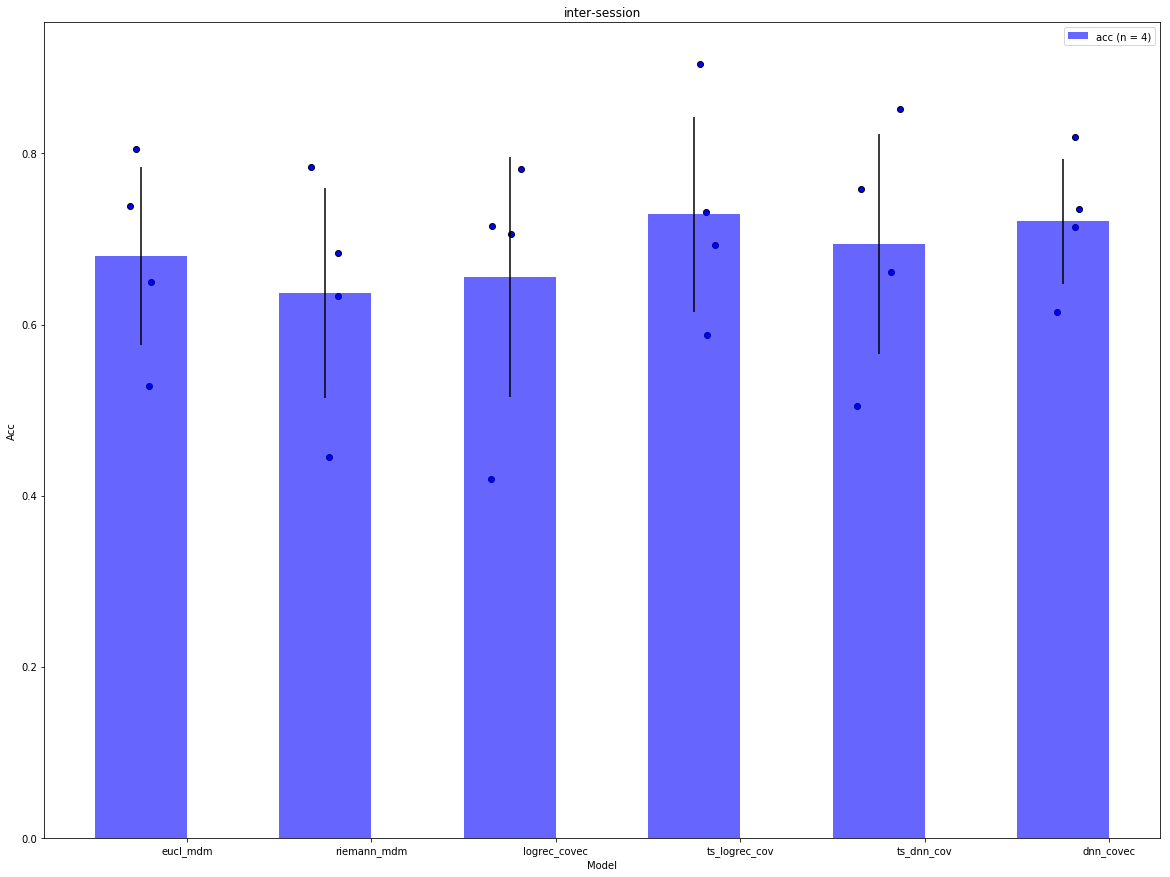

In [78]:
viz.bar_plot_scatter_comp([acc_inter], model_labels, 'inter-session', ['acc'])
#plt.ylim([0.7, 1.1])

# 6. Model on Inter-subjects

In [230]:
### This dictionary will contain the results for the inter-subjects experiments.
result_subj = {}

## 6.1 Euclidean MDM

In [231]:
result_subj = hf.train_test_intersubjects(data_per_exp, result_subj, hf.MDM(), key_result='mdm_eucl')

mg*s1* rr*s1* 0.32476875642343267
mg*s1* rr*s2* 0.3470225872689938
mg*s2* rr*s1* 0.26618705035971224
mg*s2* rr*s2* 0.27618069815195073
rr*s1* mg*s1* 0.2964554242749731
rr*s1* mg*s2* 0.49897750511247446
rr*s2* mg*s1* 0.4317937701396348
rr*s2* mg*s2* 0.6175869120654397
avg: 0.38237158797457643


## 6.2 Riemann MDM

In [232]:
result_subj = hf.train_test_intersubjects(data_per_exp, result_subj, pyriemann.classification.MDM(), key_result='mdm_riemann')

mg*s1* rr*s1* 0.2723535457348407
mg*s1* rr*s2* 0.2679671457905544
mg*s2* rr*s1* 0.3823227132579651
mg*s2* rr*s2* 0.41683778234086244
rr*s1* mg*s1* 0.2953813104189044
rr*s1* mg*s2* 0.4233128834355828
rr*s2* mg*s1* 0.21160042964554243
rr*s2* mg*s2* 0.5184049079754601
avg: 0.34852258982496404


## 6.3 Log Reg on cov

In [233]:
result_subj = hf.train_test_intersubjects(data_per_exp, result_subj, LogisticRegression(solver='lbfgs', multi_class='multinomial'), key_result='log_covec', data_type='covec')

mg*s1* rr*s1* 0.4398766700924974
mg*s1* rr*s2* 0.6437371663244353
mg*s2* rr*s1* 0.3432682425488181
mg*s2* rr*s2* 0.3131416837782341
rr*s1* mg*s1* 0.39742212674543503
rr*s1* mg*s2* 0.5940695296523517
rr*s2* mg*s1* 0.46938775510204084
rr*s2* mg*s2* 0.6738241308793456
avg: 0.48434091314039474


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


## 6.4 Tangeant + Log Reg

In [234]:
estimators = []
estimators.append(('ts', TangentSpace()))
estimators.append(('lr', LogisticRegression(solver='lbfgs', multi_class='multinomial')))
pipeline_tang_lr = Pipeline(estimators)

In [235]:
result_subj = hf.train_test_intersubjects(data_per_exp, result_subj, pipeline_tang_lr, key_result='ts_log')

mg*s1* rr*s1* 0.18705035971223022
mg*s1* rr*s2* 0.2515400410677618
mg*s2* rr*s1* 0.24049331963001028
mg*s2* rr*s2* 0.2515400410677618
rr*s1* mg*s1* 0.2749731471535983
rr*s1* mg*s2* 0.7280163599182005
rr*s2* mg*s1* 0.4253490870032223
rr*s2* mg*s2* 0.6789366053169734
avg: 0.37973737010871983


## 6.5 DNN on Cov

generate_weights = create_model(weights=None)

In [236]:
if TRAIN_DNN:
    result_subj = hf.train_test_intersubjects(data_per_exp, result_subj, KerasClassifier(build_fn=create_model_covariance, epochs=100, verbose=0), key_result='dnn_covec', data_type='covec')

mg*s1* rr*s1* 0.4039054470709147
mg*s1* rr*s2* 0.7987679671457906
mg*s2* rr*s1* 0.381294964028777
mg*s2* rr*s2* 0.3275154004106776
rr*s1* mg*s1* 0.44360902255639095
rr*s1* mg*s2* 0.6431492842535788
rr*s2* mg*s1* 0.43823845327604727
rr*s2* mg*s2* 0.6400817995910021
avg: 0.5095702922916473


## 6.6 Tangeant + DNN

In [237]:
estimators = []
#estimators.append(('standardize', StandardScaler()))
estimators.append(('ts', TangentSpace()))
estimators.append(('dnn', KerasClassifier(build_fn=create_model_covariance, epochs=100, verbose=0)))
pipeline_tang_dnn = Pipeline(estimators)

In [238]:
if TRAIN_DNN:
    result_subj = hf.train_test_intersubjects(data_per_exp, result_subj, pipeline_tang_dnn, key_result='ts_dnn')

mg*s1* rr*s1* 0.45837615621788286
mg*s1* rr*s2* 0.4887063655030801
mg*s2* rr*s1* 0.24152106885919836
mg*s2* rr*s2* 0.2515400410677618
rr*s1* mg*s1* 0.3426423200859291
rr*s1* mg*s2* 0.7269938650306749
rr*s2* mg*s1* 0.44253490870032225
rr*s2* mg*s2* 0.6912065439672802
avg: 0.4554401586790162


## 6.7 Tangent with different powers

In [243]:
importlib.reload(gf)

<module 'geom_function' from '/code/emg_sign_recognition/geom_function.py'>

In [262]:
result_subj = gf.run_intersubj_on_powers(
    result_subj, data_per_exp, 
    key_estimator='lr', key_result='ts_lr_cov', powers=POWERS)  

mg*s1* rr*s1* 0.17266187050359713
mg*s1* rr*s2* 0.24845995893223818
mg*s2* rr*s1* 0.23227132579650564
mg*s2* rr*s2* 0.25051334702258726
rr*s1* mg*s1* 0.3200859291084855
rr*s1* mg*s2* 0.6329243353783232
rr*s2* mg*s1* 0.4414607948442535
rr*s2* mg*s2* 0.6728016359918201
avg: 0.3713973996972263
mg*s1* rr*s1* 0.17574511819116137
mg*s1* rr*s2* 0.24948665297741274
mg*s2* rr*s1* 0.2312435765673176
mg*s2* rr*s2* 0.25051334702258726
rr*s1* mg*s1* 0.3157894736842105
rr*s1* mg*s2* 0.6329243353783232
rr*s2* mg*s1* 0.439312567132116
rr*s2* mg*s2* 0.6728016359918201
avg: 0.3709770883681186
mg*s1* rr*s1* 0.17985611510791366
mg*s1* rr*s2* 0.24948665297741274
mg*s2* rr*s1* 0.2302158273381295
mg*s2* rr*s2* 0.25051334702258726
rr*s1* mg*s1* 0.31149301825993553
rr*s1* mg*s2* 0.630879345603272
rr*s2* mg*s1* 0.439312567132116
rr*s2* mg*s2* 0.6738241308793456
avg: 0.37069762554008906
mg*s1* rr*s1* 0.18396711202466598
mg*s1* rr*s2* 0.24948665297741274
mg*s2* rr*s1* 0.2312435765673176
mg*s2* rr*s2* 0.2505133470

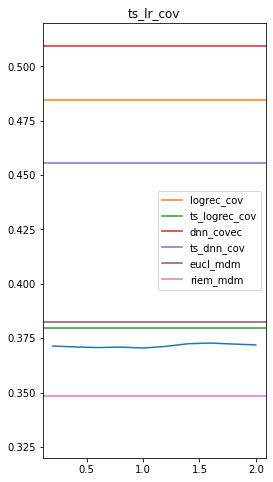

In [263]:
gf.plot_intersubj_on_powers(result_subj, key_result='ts_lr_cov', powers=POWERS, ylim=(0.32, 0.52))

In [264]:
result_subj = gf.run_intersubj_on_powers(
    result_subj, data_per_exp, 
    key_estimator='dnn', key_result='ts_dnn_cov', powers=POWERS)  

mg*s1* rr*s1* 0.4265159301130524
mg*s1* rr*s2* 0.4917864476386037
mg*s2* rr*s1* 0.38848920863309355
mg*s2* rr*s2* 0.27104722792607805
rr*s1* mg*s1* 0.26852846401718583
rr*s1* mg*s2* 0.6932515337423313
rr*s2* mg*s1* 0.4070891514500537
rr*s2* mg*s2* 0.6789366053169734
avg: 0.4532055711046715
mg*s1* rr*s1* 0.4295991778006166
mg*s1* rr*s2* 0.49075975359342916
mg*s2* rr*s1* 0.4316546762589928
mg*s2* rr*s2* 0.3470225872689938
rr*s1* mg*s1* 0.29108485499462944
rr*s1* mg*s2* 0.6850715746421268
rr*s2* mg*s1* 0.4113856068743287
rr*s2* mg*s2* 0.6912065439672802
avg: 0.47222309692504966
mg*s1* rr*s1* 0.43782117163412126
mg*s1* rr*s2* 0.4917864476386037
mg*s2* rr*s1* 0.4182939362795478
mg*s2* rr*s2* 0.2936344969199179
rr*s1* mg*s1* 0.24060150375939848
rr*s1* mg*s2* 0.6881390593047034
rr*s2* mg*s1* 0.4092373791621912
rr*s2* mg*s2* 0.7024539877300614
avg: 0.4602459978035681
mg*s1* rr*s1* 0.42137718396711205
mg*s1* rr*s2* 0.4794661190965092
mg*s2* rr*s1* 0.4316546762589928
mg*s2* rr*s2* 0.317248459958

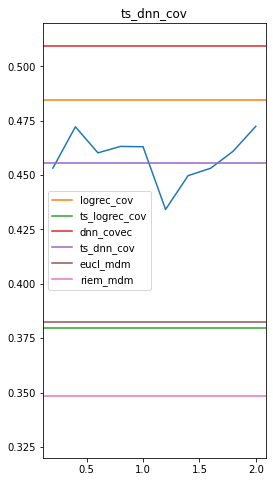

In [265]:
gf.plot_intersubj_on_powers(result_subj, key_result='ts_dnn_cov', powers=POWERS, ylim=(0.32, 0.52))

# Plotting

In [88]:
acc_subj = np.array([model['acc'] for key, model in result_subj.items()]).transpose()
model_labels = [x for x in result_subj.keys()]

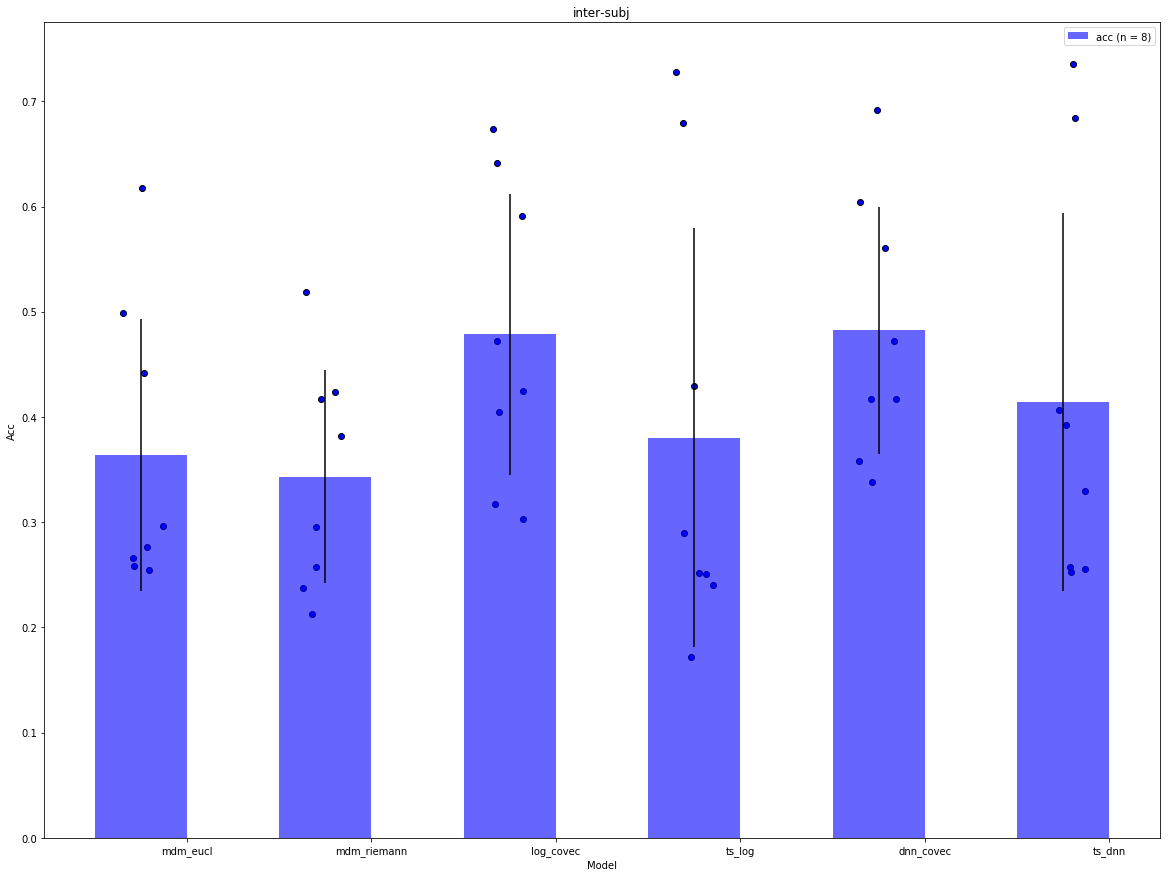

In [89]:
viz.bar_plot_scatter_comp([acc_subj], model_labels, 'inter-subj', ['acc'])

In [90]:
b = time.time()
print(b - a)

640.8950803279877
